In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from emcee.autocorr import integrated_time

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap import convergence
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Test the convergency of the sampling chains

* Using three different approaches
    1. K-L divergence 
    2. Autocorrelation time
    3. Gelman-Rubin test

In [2]:
# Old result: 
# -155.79388568381947 [ 6.03179566e-01  1.18461568e+01 -1.65986740e-02  2.63625215e-03
#   6.52983173e-01 -1.77764693e-01  3.77075453e-01]

In [3]:
test_dir = '../model/'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_final_4.yaml')

# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_final_4_sample.npz')

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

print(np.nanmax(mod_result_lnprob), mod_result_best)

# Running model: asap_test_final_4
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   250 x  2 steps of burn-in
#    Use   256 walkers with        kde moves for  5000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

In [24]:
_, n_step, n_dim = mod_result_chains.shape

mod_result_best = np.nanmean(mod_result_chains[:, -int(n_step * 0.1):, :].reshape([-1, n_dim]), axis=0)

print(mod_result_best)

[ 6.04810774e-01  1.18470300e+01 -6.91972205e-03  7.03347839e-03
  6.51020419e-01 -1.73914122e-01  3.75067791e-01]


In [5]:
# The results from the 3-stage burn-in results
burnin_file_1 = os.path.join(test_dir, 'asap_test_final_4_burnin_1.npz')
burnin_file_2 = os.path.join(test_dir, 'asap_test_final_4_burnin_2.npz')
burnin_file_3 = os.path.join(test_dir, 'asap_test_final_4_burnin_2.npz')

# Load the burn-in results
(mod_burnin_samples_1, 
 mod_burnin_chains_1, 
 mod_burnin_lnprob_1, 
 mod_burnin_best_1, _, _) = io.load_npz_results(burnin_file_1)

(mod_burnin_samples_2, 
 mod_burnin_chains_2, 
 mod_burnin_lnprob_2, 
 mod_burnin_best_2, _, _) = io.load_npz_results(burnin_file_2)

(mod_burnin_samples_3, 
 mod_burnin_chains_3, 
 mod_burnin_lnprob_3, 
 mod_burnin_best_3, _, _) = io.load_npz_results(burnin_file_3)

mod_burnin_chains = np.concatenate([
    mod_burnin_chains_1, mod_burnin_chains_2, mod_burnin_chains_3], axis=1)

In [6]:
print(mod_result_chains.shape)

(256, 5000, 7)


### Estimate the auto-correlation time

* References:
    1. [Autocorrelation analysis & convergence](https://emcee.readthedocs.io/en/latest/tutorials/autocorr/)
    2. [Autocorrelation time: is taking the mean the right thing to do?](https://github.com/dfm/emcee/issues/209)
    3. [A Smarter Autocorrelation Time](https://github.com/dfm/emcee/issues/214)

In [72]:
tau = np.mean([integrated_time(walker, c=10, tol=10) for walker in mod_result_chains[:, 500:, :]], axis=0)

print(tau)

[289.22750559]


### Gelman-Rubin Test

* Reference:
    1. [Convergence of the Affine Invariant Ensemble Sampler](http://joergdietrich.github.io/emcee-convergence.html)
    2. [The Gelman Rubin Statistic and emcee](http://greg-ashton.physics.monash.edu/the-gelman-rubin-statistic-and-emcee.html)
    
* Note: you should not compute the G–R statistic using multiple chains in the same emcee ensemble because the chains are not independent!

In [58]:
convergence.gelman_rubin(mod_result_chains[:, 2000:, ])

array([4.13358348, 4.26178896, 4.15055861, 4.09745339, 3.56751241,
       3.74577954, 3.98391551])

### Performs a Kullback-Leibler divergence test for convergence

* Reference
    1. [Convergency test in `prospector`](https://github.com/bd-j/prospector/blob/master/prospect/fitting/convergence.py)

In [23]:
convergence.convergence_check(
    mod_result_chains[:, 3000:, :], convergence_check_interval=50, convergence_chunks=50,
    convergence_stable_points_criteria=3, convergence_nhist=20,
    convergence_kl_threshold=0.018)

(True,
 {'iteration': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
          650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
         1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700,
         1750, 1800, 1850, 1900, 1950, 2000]),
  'kl_test': array([[0.00599072, 0.01767894, 0.01572868, 0.02060637, 0.01488262,
          0.00976469, 0.0153442 ],
         [0.00716561, 0.01155045, 0.01022655, 0.01251514, 0.03021927,
          0.01099135, 0.00902199],
         [0.01177365, 0.00855485, 0.01516467, 0.01102294, 0.00612919,
          0.00890316, 0.01831623],
         [0.01162599, 0.00995912, 0.01027167, 0.00829344, 0.01316787,
          0.00936491, 0.01037978],
         [0.0108676 , 0.01150316, 0.02944885, 0.01628012, 0.0139532 ,
          0.00875279, 0.00995922],
         [0.00271732, 0.00571557, 0.00763059, 0.01902905, 0.00702628,
          0.00947033, 0.02010966],
         [0.00975961, 0.00996479, 0.01207141, 0.01060593, 0.0111691

### Corner and trace plot 

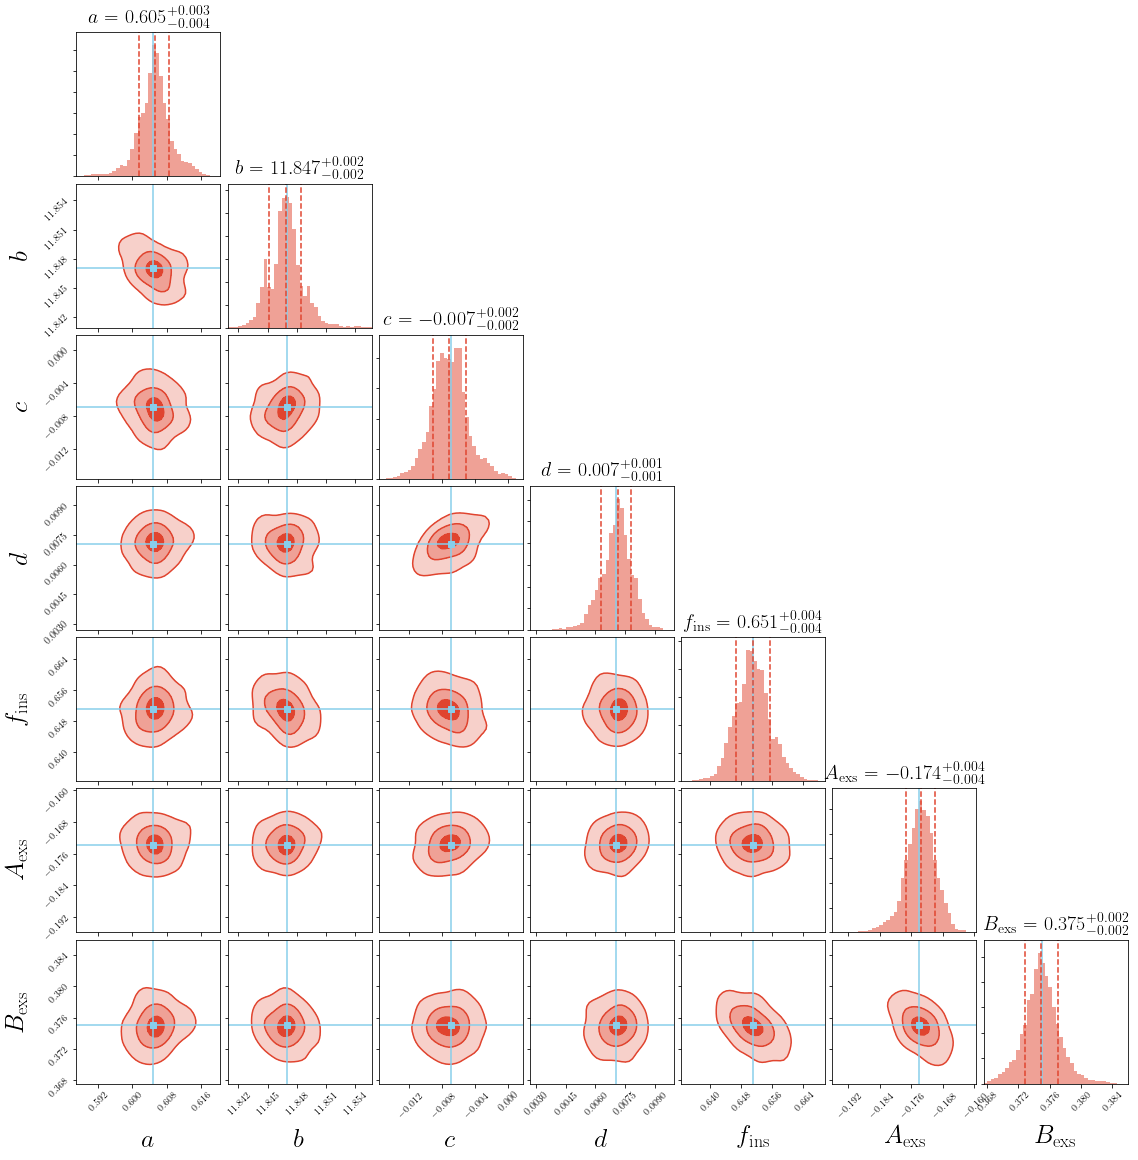

In [26]:
params_label = [r'$a$', r'$b$', r'$c$', r'$d$', 
                r'$f_{\rm ins}$', r'$A_{\rm exs}$', r'$B_{\rm exs}$']

params_range = [(0.585, 0.622), (11.831, 11.854), 
                (-0.024, 0.007), (-0.005, 0.0039), 
                (0.629, 0.679), 
                (-0.22, -0.162), (0.29, 0.41)]
title_fmt = '.3f'

mod_samples_use = mod_result_chains[:, 1000:, :].reshape([-1, 7])

mod_corner = plotting.plot_mcmc_corner(
    mod_samples_use, params_label, truths=mod_result_best, truth_color='skyblue',
    **{'title_fmt': title_fmt, 'ranges': params_range, 'plot_datapoints': False})

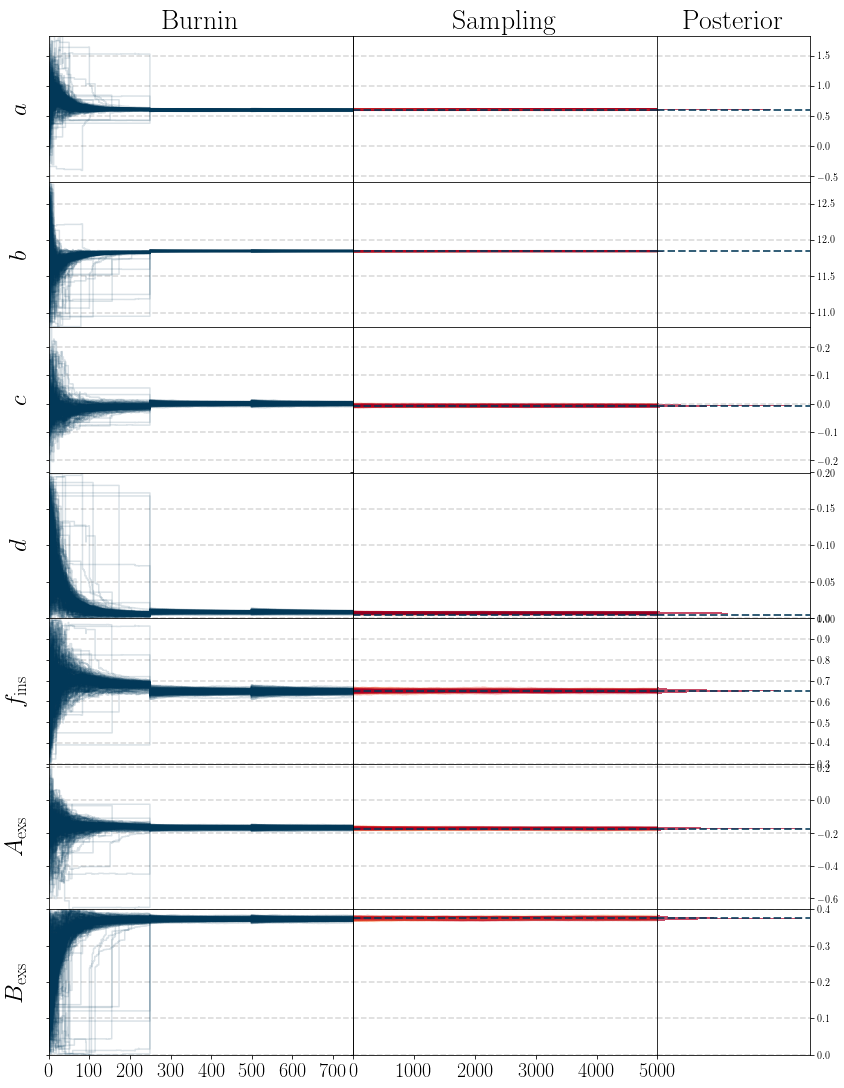

In [9]:
mod_trace = plotting.plot_mcmc_trace(
    mod_result_chains, params_label, 
    mcmc_best=mod_result_best, mcmc_burnin=mod_burnin_chains, 
    burnin_alpha=0.15, trace_alpha=0.12)